In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import math
from imblearn.over_sampling import RandomOverSampler

In [2]:
path = "../germany_dataset/train.csv"
df = pd.read_csv(path)
df = df.dropna()
filename="ResNet50-2"

In [3]:
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,18,16


In [4]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,length,height
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,39.197786,38.765998
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,21.821369,20.828697
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,15.000000,15.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,24.000000,24.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,33.000000,32.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,47.000000,47.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,203.000000,185.000000


In [5]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = "../germany_dataset/"
testdir = "../germany_dataset/test.csv"
Epochs=100
train_length = len(df)
Y_col_name="ClassId"

In [6]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


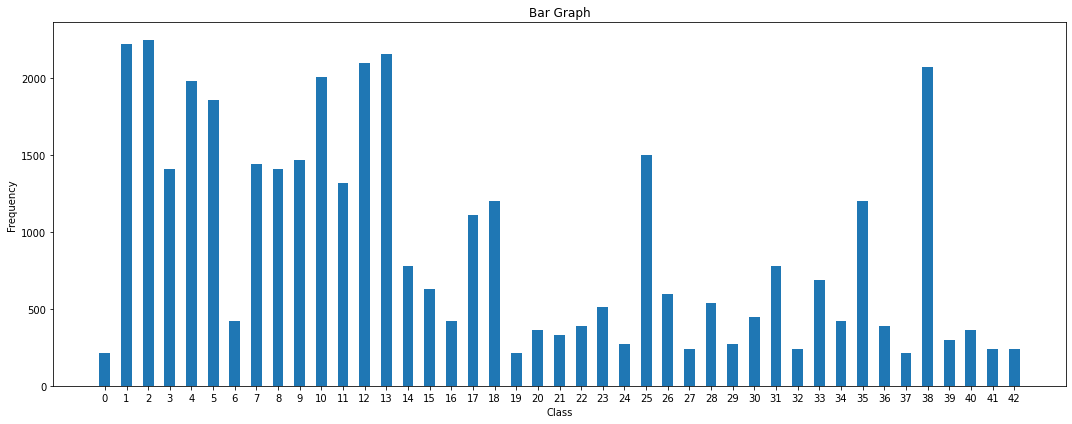

In [7]:
#Statistics of Data
viewStatistics(df)

In [8]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


Total Training Examples :  96750


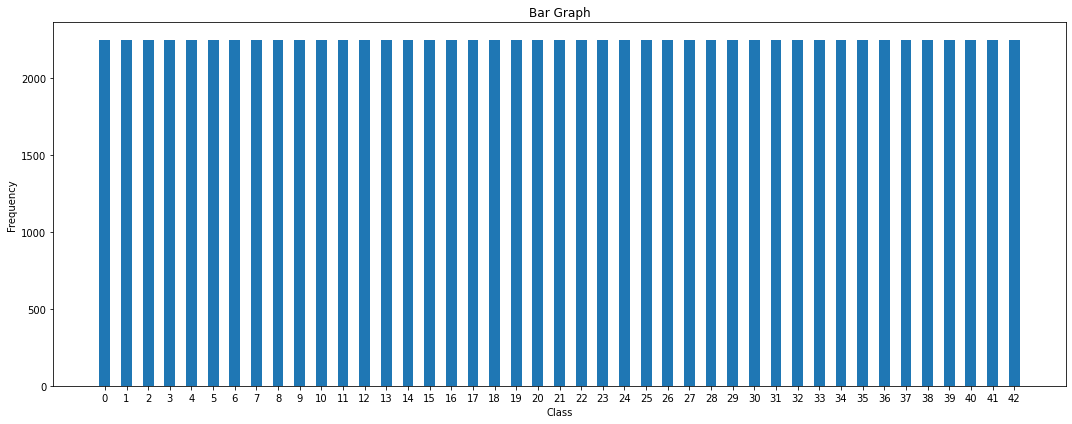

In [9]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled
df[Y_col_name].astype(str)

viewStatistics(df)

In [10]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,27,26,5,5,22,20,Train/20/00020_00000_00000.png,17,15,20
1,28,27,5,6,23,22,Train/20/00020_00000_00001.png,18,16,20
2,29,26,6,5,24,21,Train/20/00020_00000_00002.png,18,16,20
3,28,27,5,6,23,22,Train/20/00020_00000_00003.png,18,16,20
4,28,26,5,5,23,21,Train/20/00020_00000_00004.png,18,16,20


In [11]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[6])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title(directory+val[6])
        print(directory+val[6])
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[7])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+str(val[6]))
    ax.axis('off')
    

../germany_dataset/Train/15/00015_00015_00023.png
../germany_dataset/Train/11/00011_00036_00027.png
../germany_dataset/Train/8/00008_00045_00018.png
../germany_dataset/Train/26/00026_00008_00021.png
../germany_dataset/Train/40/00040_00009_00022.png


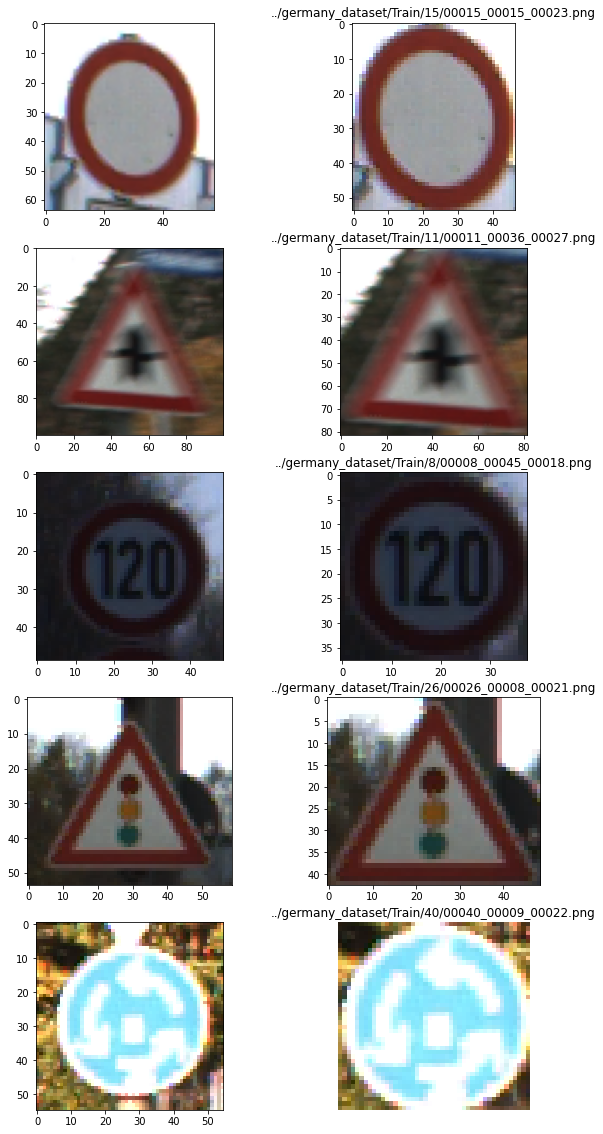

In [12]:
showExamples(df)

In [13]:
# Load pre-trained ResNet50 model with random weights
model = ResNet50(weights=None, input_shape=(resize_x, resize_y, 3), classes=num_of_classes)

# Display the model summary
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
print(df["ClassId"].dtype)
df["ClassId"] = df["ClassId"].astype(str)
print(df["ClassId"].dtype)

int64
object


In [16]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,27,26,5,5,22,20,Train/20/00020_00000_00000.png,17,15,20
1,28,27,5,6,23,22,Train/20/00020_00000_00001.png,18,16,20
2,29,26,6,5,24,21,Train/20/00020_00000_00002.png,18,16,20
3,28,27,5,6,23,22,Train/20/00020_00000_00003.png,18,16,20
4,28,26,5,5,23,21,Train/20/00020_00000_00004.png,18,16,20


In [17]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self,dataframe, x1_col, y1_col, x2_col, y2_col, Path,directory, preprocessing_function=None, **kwargs):
        super().__init__(preprocessing_function=preprocessing_function, **kwargs)
        self.dataframe=dataframe
        self.directory = directory
        self.x1_col = x1_col
        self.y1_col = y1_col
        self.x2_col = x2_col
        self.y2_col = y2_col
        self.Path   = Path
        

    def flow_from_dataframe(self, *args, **kwargs):
        generator = super().flow_from_dataframe(*args, **kwargs)
        generator.Path = self.Path
        return generator

    def __getitem__(self, index):
        # Override the __getitem__ method to load and preprocess images based on coordinates
        current_batch = super().__getitem__(index)
        
        # Load original images and preprocess based on coordinates
        for i in range(len(current_batch[0])):
            x1 = self.dataframe[self.x1_col].iloc[index * self.batch_size + i]
            y1 = self.dataframe[self.y1_col].iloc[index * self.batch_size + i]
            x2 = self.dataframe[self.x2_col].iloc[index * self.batch_size + i]
            y2 = self.dataframe[self.y2_col].iloc[index * self.batch_size + i]
            original_image_path = self.dataframe[self.Path].iloc[index * self.batch_size + i]
            original_image = Image.open(directory+original_image_path)
            region = original_image.crop((x1, y1, x2, y2))
            region_array = np.array(region)
            
            # Apply preprocessing_function if specified
            if self.preprocessing_function:
                region_array = self.preprocessing_function(region_array)

            current_batch[0][i] = region_array

        return current_batch

In [18]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,29,28,6,5,23,22,Train/42/00042_00005_00005.png,17,17,42
1,30,31,5,6,25,26,Train/10/00010_00028_00005.png,20,20,10
2,70,69,7,6,64,63,Train/36/00036_00002_00025.png,57,57,36
3,32,33,5,6,27,28,Train/41/00041_00000_00007.png,22,22,41
4,50,51,5,6,45,46,Train/40/00040_00005_00000.png,40,40,40


In [20]:
datagen  = CustomImageDataGenerator(
    df,
    "Roi.X1",
    "Roi.Y1",
    "Roi.X2",
    "Roi.Y2",
    "Path",
    directory,
    rescale=1./255,  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  ,
    validation_split = 0.2,
    samplewise_center=True
)

train_generator = datagen.flow_from_dataframe(
     df,
    x_col='Path',
    y_col="ClassId",
    target_size=(resize_x,resize_y),
    batch_size=32,
    directory=directory,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
  df,
    x_col='Path',
    y_col="ClassId",
    target_size=(resize_x,resize_y),
    batch_size=32,
    directory=directory,
    class_mode='sparse',
    subset='validation'
)

Found 77400 validated image filenames belonging to 43 classes.
Found 19350 validated image filenames belonging to 43 classes.


In [21]:
starting_time = time.time()

history = model.fit( train_generator,
    steps_per_epoch=len(train_generator),
    epochs=Epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/25
2419/2419 [==============================] - 594s 242ms/step - loss: 3.4921 - accuracy: 0.1545 - val_loss: 4.0817 - val_accuracy: 0.2778
Epoch 2/25
2419/2419 [==============================] - 598s 247ms/step - loss: 2.1694 - accuracy: 0.4060 - val_loss: 7.7612 - val_accuracy: 0.4484
Epoch 3/25
2419/2419 [==============================] - 710s 294ms/step - loss: 2.2219 - accuracy: 0.4032 - val_loss: 2.3413 - val_accuracy: 0.4623
Epoch 4/25
2419/2419 [==============================] - 528s 218ms/step - loss: 1.3657 - accuracy: 0.5879 - val_loss: 1.7123 - val_accuracy: 0.5839
Epoch 5/25
2419/2419 [==============================] - 526s 217ms/step - loss: 0.9530 - accuracy: 0.7037 - val_loss: 0.9034 - val_accuracy: 0.7531
Epoch 6/25
2419/2419 [==============================] - 521s 215ms/step - loss: 0.6829 - accuracy: 0.7841 - val_loss: 3.3496 - val_accuracy: 0.8168
Epoch 7/25
2419/2419 [==============================] - 520s 215ms/step - loss: 0.5881 - accuracy: 0.8152 - val_

In [22]:
#Saving the model
model.save(filename)

INFO:tensorflow:Assets written to: ResNet50/assets


/raid/home/dgx1442/finalYearProject/venv/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

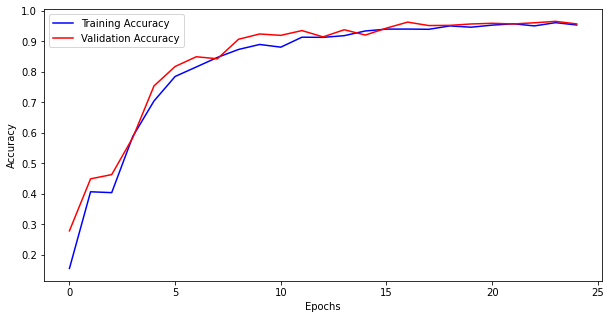

In [24]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

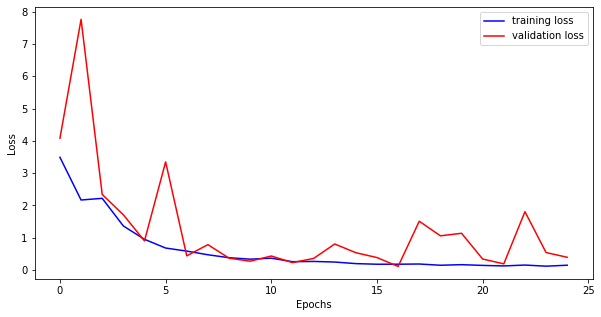

In [25]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [26]:
#Loading weights into CNN model 
# model = tf.keras.models.load_model("CNN_SimpleLayered")

In [27]:
df_test = pd.read_csv(testdir)
df_test["ClassId"] =df_test["ClassId"].astype(str)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Total Training Examples :  12630


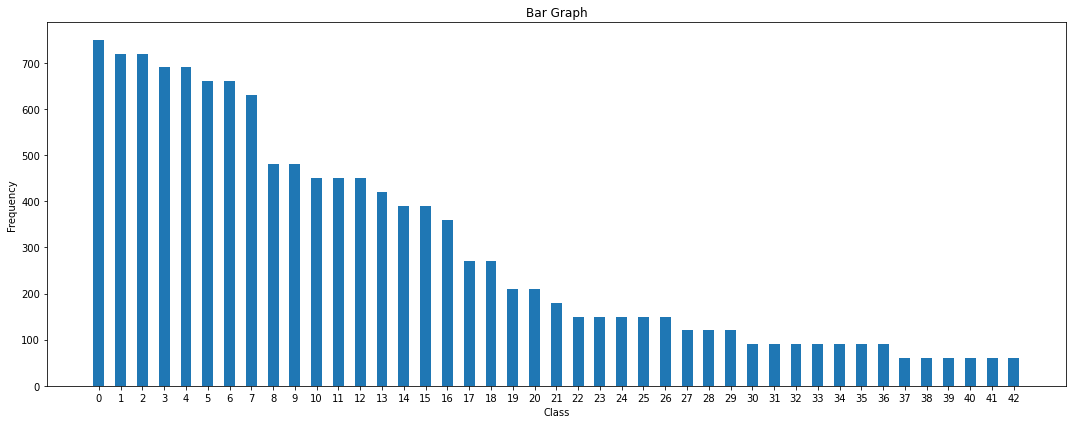

In [28]:
viewStatistics(df_test)

In [29]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


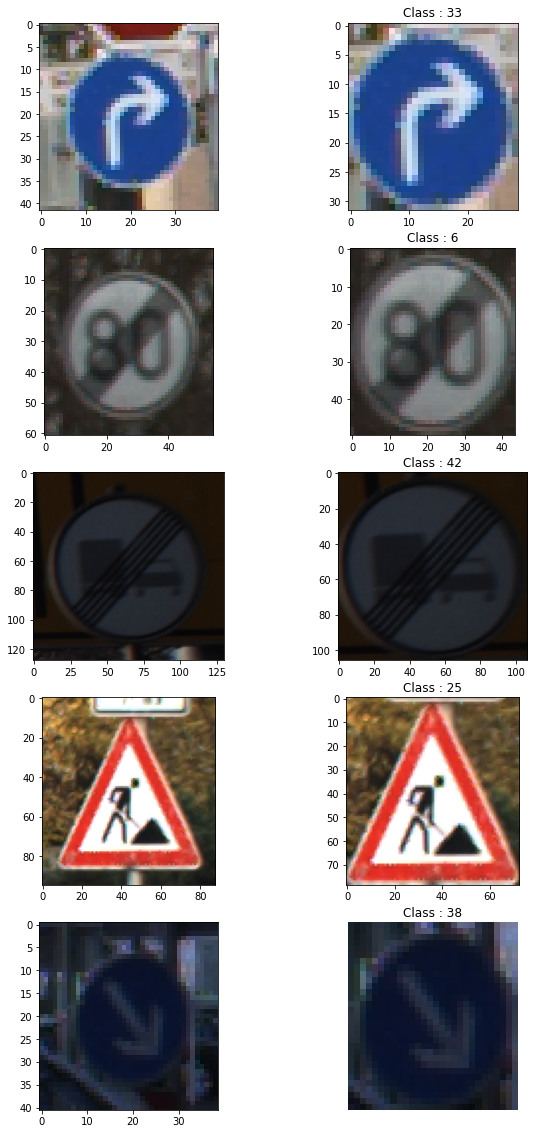

In [30]:
showTestExamples(df_test)

In [31]:
X = df_test.drop(Y_col_name, axis=1)
y = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_test = pd.DataFrame(X_resampled, columns=X.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [32]:
test_datagen = CustomImageDataGenerator(df_test,"Roi.X1",
                                   "Roi.Y1",
                                   "Roi.X2",
                                   "Roi.Y2",
                                   "Path",
                                   directory,
                                   rescale=1./255)  # You can add other preprocessing options as needed

batch_size = 32  # Adjust based on your requirements

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='Path',
    y_col='ClassId',
    directory=directory,
    target_size=(resize_x, resize_y),  # Adjust based on your model's input size
    batch_size=batch_size,
    class_mode='sparse',  # Adjust based on your task
    shuffle=False  # Set to False for testing to maintain the order
)

Found 32250 validated image filenames belonging to 43 classes.


In [33]:
y_test = test_generator.classes
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

In [34]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  47.47286821705426

Confusion Matrix:
 [[142 332   0 ...   0   0   0]
 [  5 163   0 ...   2   1   0]
 [  0   0 554 ...   1   0  56]
 ...
 [  0  74   3 ... 212   9   0]
 [  0  63   0 ...  10 118   3]
 [  0   3  94 ...   0   0 568]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,0.75,0.19,0.30,750
1,1,0.17,0.22,0.19,750
2,2,0.79,0.74,0.76,750
3,3,0.61,0.52,0.56,750
4,4,1.00,0.49,0.65,750
5,5,0.96,0.66,0.78,750
6,6,1.00,0.58,0.73,750
7,7,0.86,0.62,0.72,750
8,8,1.00,0.77,0.87,750
9,9,1.00,0.71,0.83,750


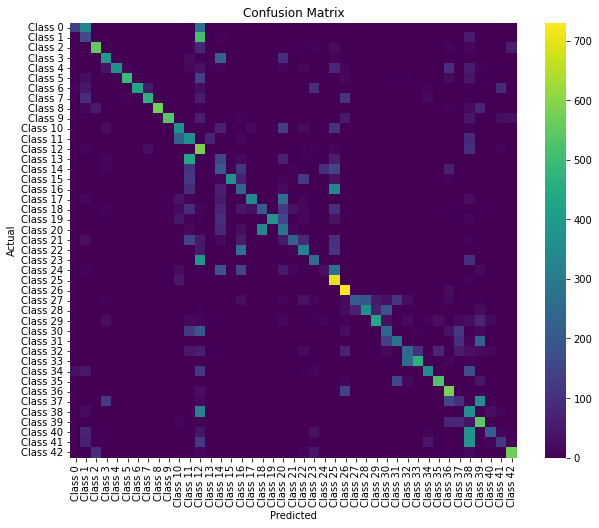

In [35]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()